In [1]:
# Training the model
from torch_agent import MyTorchAgent
from collections import deque
from unityagents import UnityEnvironment
import numpy as np
import torch
import time
from matplotlib import pyplot as plt

#create agent
agent = MyTorchAgent(state_size=37, action_size=4,tau=10e-3,batchSize=64,gamma=0.99)


modelPath = 'models/model.pth'
final_eps = 0.01
#set to true if training should be run, otherwise a simulation is run with the trained model
trainMode = True


#create banana environement
env = UnityEnvironment(file_name="Banana.exe")

# use this environment when you are in the udacity workspace
#env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

#env = UnityEnvironment(file_name="...")
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=trainMode)[brain_name]
# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 1
Number of actions: 4


Episode 100	Average Score: 0.89
Episode 200	Average Score: 4.75
Episode 300	Average Score: 7.53
Episode 400	Average Score: 10.12
Episode 500	Average Score: 10.54
Episode 600	Average Score: 12.16
Episode 700	Average Score: 12.29
Episode 782	Average Score: 13.04
Environment solved in 782 episodes!	Average Score: 13.04
Training time: 937.5089101791382


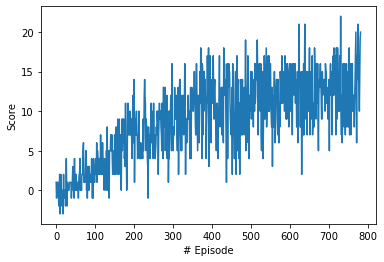

In [2]:
'''
   Implementation of deep q learning

       n_episodes (int): maximum number of training episodes
       eps_start (float): start value of epsilon, for epsilon-greedy action selection
       eps_end (float): min value of epsilon
       eps_decay (float): factor for decreasing epsilon
       trainMode (bool): specifies if algorithm is run in train or test mode (i.e. loading a trained model and simulating agent behaviour)
'''

def dqn(n_episodes=2000, eps_start=1.0, eps_end=final_eps, eps_decay=0.995, trainMode = True):
    trainingTime = -1
    startTime = time.time()
    scores = []  # list containing scores from each episode
    scores_history = deque(maxlen=100)  # last 100 scores
    eps = eps_start  # initialize epsilon
    for i_episode in range(1, n_episodes + 1):
        env_info = env.reset(train_mode=trainMode)[brain_name]  # reset the environment
        state = env_info.vector_observations[0]  # get the current state
        score = 0  # initialize the score
        while(True):
            action = agent.doAction(state, eps,trainMode=trainMode)  # select an action
            env_info = env.step(action)[brain_name]  # send the action to the environment
            next_state = env_info.vector_observations[0]  # get the next state
            reward = env_info.rewards[0]  # get the reward
            done = env_info.local_done[0]  # see if episode has finished
            if trainMode:
                agent.step(state, action, reward, next_state, done)  # do the learning

            score += reward  # update the score
            state = next_state  # update the state with the next one
            if done:  # exit loop on end of episode
                break
        #save current score
        scores_history.append(score)
        scores.append(score)
        eps = max(eps_end, eps_decay * eps)  # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_history)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_history)))
        if trainMode and np.mean(scores_history) >= 13.0:
            trainingTime = time.time() - startTime
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode,np.mean(scores_history)))
            torch.save(agent.qnetwork_local.state_dict(), modelPath)
            break

    return scores,trainingTime


if not trainMode:
    # simulate agent with learnt weights in environemt
    agent.qnetwork_local.load_state_dict(torch.load(modelPath))
    scores, trainingTime = dqn(trainMode=trainMode,eps_start=0,eps_end=0,n_episodes=1)
else:
    scores, trainingTime = dqn()
    print("Training time: {0}".format(trainingTime))
    # plot the scores
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('# Episode')
    plt.savefig("plots/scoresPerEpisode.png")
    plt.show()

env.close()
